# CIA cross sections from HITRAN into NemesisPy

In this notebook, we aim to provide an example of how the functions in the CIA class of NemesisPy can be used to read the CIA cross sections tabulated in [HITRAN](https://hitran.org/cia/), and converted into an HDF5 file with the format required by NemesisPy.

Note that the input format for the CIA cross sections in the latest version of NemesisPy is different than that in the Fortran version of NEMESIS. Nevertheless, the calculations regarding CIA is equivalent in both versions of the code. In addition, while the CIA look-up tables in NEMESIS are listed in units of cm$^{-1}$ amagat$^{-2}$, the cross sections in the CIA look-up tables in NemesisPy are listed in units of cm$^{5}$ molecule$^{-1}$, following the HITRAN convention.

Nevertheless, when reading the look-up table from the .cia file (assumed to be used with NEMESIS), the change in units from cm$^{-1}$ amagat$^{-2}$ from cm$^{5}$ molecule$^{-1}$ is performed automatically. On the other hand, if the CIA table is read from the HDF5 file, then the units are expected to be directly in cm$^{5}$ molecule$^{-1}$.

In [1]:
from NemesisPy import *
import scipy
import numpy as np

## 1. Reading the HITRAN CIA file

In NemesisPy, we have included the function $\textit{read_cia_hitran_file()}$ to read the CIA cross sections in the format tabulated in HITRAN. In this example, we are going to read the CIA cross sections of the CO$_2$-CO$_2$ absorption.

In [2]:
filename = 'CO2-CO2_2018.cia'
ncases,temp,nwave,waven,kn = read_cia_hitran_file(filename)

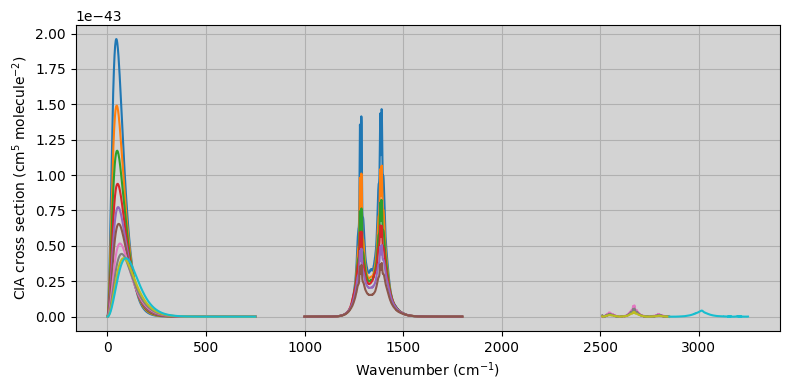

In [3]:
#Plotting all the cases
fig,ax1 = plt.subplots(1,1,figsize=(8,4))

for i in range(ncases):
    
    ax1.plot(waven[0:nwave[i],i],kn[0:nwave[i],i])
    
ax1.set_facecolor('lightgray')
ax1.grid()
ax1.set_xlabel('Wavenumber (cm$^{-1}$)')
ax1.set_ylabel('CIA cross section (cm$^{5}$ molecule$^{-2}$)')
plt.tight_layout()

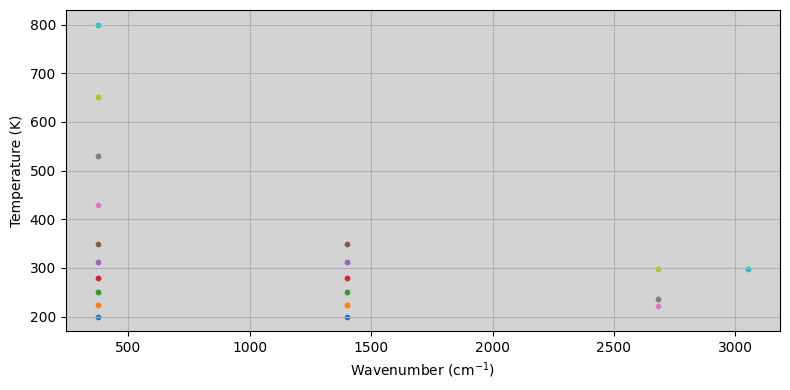

In [4]:
#Plotting the temperature and wavelength range for each case
fig,ax1 = plt.subplots(1,1,figsize=(8,4))

for i in range(ncases):
    
    ax1.scatter(np.mean(waven[0:nwave[i],i]),temp[i],s=10.)
    
ax1.set_facecolor('lightgray')
ax1.grid()
ax1.set_xlabel('Wavenumber (cm$^{-1}$)')
ax1.set_ylabel('Temperature (K)')
plt.tight_layout()

## 2. Defining the CIA data in a regular grid

In NemesisPy, we must define the CIA data in a regular grid of temperatures and wavenumbers.It can be seen that the CIA data tabulated in the HITRAN file varies in terms of spectral range and temperatures. Here, we interpolate the data into a common grid in temperature and spectral resolution and range.

In [5]:
#We divide the data in four groups
wavemean = np.zeros(ncases)
wavemin = np.zeros(ncases)
kmin = np.zeros(ncases)
for i in range(ncases):
    wavemean[i] = np.mean(waven[0:nwave[i],i])
    wavemin[i] = np.min(waven[0:nwave[i],i])
    kmin[i] = np.min(kn[0:nwave[i],i])
    
wavemeang = np.unique(wavemean)
ngroups = len(wavemeang)

### Interpolating each case to a common grid of wavelengths

In [6]:
dnu = 1.0  #Wavenumber step (cm-1)

In [7]:
#Calculating the minimum and maximum wavenumbers in the array
wavemin = 1.0e20
wavemax = 0.
for i in range(ncases):
    
    if waven[0:nwave[i],i].min()<=wavemin:
        wavemin = waven[0:nwave[i],i].min()
    if waven[0:nwave[i],i].max()>=wavemax:
        wavemax = waven[0:nwave[i],i].max()
        
wavemin = int(wavemin)
wavemax = int(wavemax)

waveg = np.arange(wavemin,wavemax+dnu,dnu)
nwaveg = len(waveg)

kgrid = np.zeros((nwaveg,ncases))

for i in range(ncases):
    
    iin = np.where( (waveg>=waven[0:nwave[i],i].min()) & (waveg<=waven[0:nwave[i],i].max()) )[0]
    
    s = scipy.interpolate.interp1d(waven[0:nwave[i],i],kn[0:nwave[i],i])
    
    kgrid[iin,i] = s(waveg[iin])
    
#Removing negative values from the k-tables
ineg = np.where(kgrid<0.0)
kgrid[ineg] = 0.0


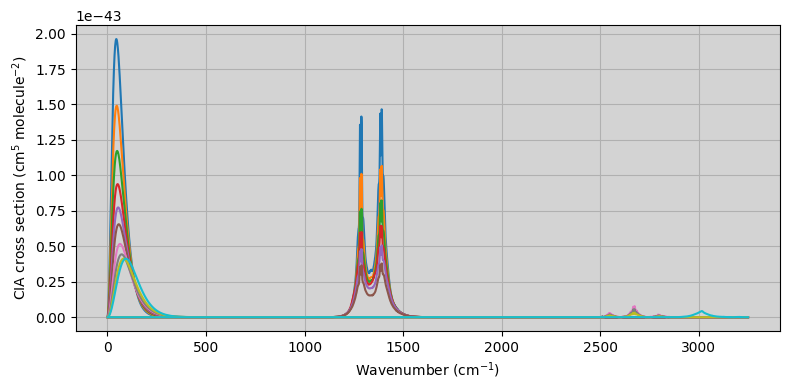

In [8]:
#Plotting all the cases
fig,ax1 = plt.subplots(1,1,figsize=(8,4))

for i in range(ncases):
    
    ax1.plot(waveg,kgrid[:,i])
    
ax1.set_facecolor('lightgray')
ax1.grid()
ax1.set_xlabel('Wavenumber (cm$^{-1}$)')
ax1.set_ylabel('CIA cross section (cm$^{5}$ molecule$^{-2}$)')
plt.tight_layout()

### Interpolating the cross sections to an even grid of temperatures

In [9]:
temp_grid = np.array([200.,224.,250.,280.,313.,350.,430.,529.,651.,800.])
ntempg = len(temp_grid)

#Dividing all the cases into groups so that they are correctly interpolated in their respective temperature ranges
igroup = [1,1,1,1,1,1,1,1,1,1,2,2,2,2,2,2,3,3,3,4]

In [10]:
ingroup = np.unique(igroup)
ngroups = len(ingroup)

ktot = np.zeros((nwaveg,ntempg))
for i in range(ngroups):
    
    ispec = np.where(igroup==ingroup[i])[0]
    
    if len(ispec)>1:
    
        kgroup = kgrid[:,ispec]
        tempgroup = temp[ispec]

        s = scipy.interpolate.interp1d(tempgroup,kgroup,axis=1,bounds_error=False,fill_value=(kgroup[:,0], kgroup[:,-1]))

        ktot[:,:] = ktot[:,:] + s(temp_grid)
        
    else:
        
        ktot[:,:] = ktot[:,:] + kgrid[:,ispec]

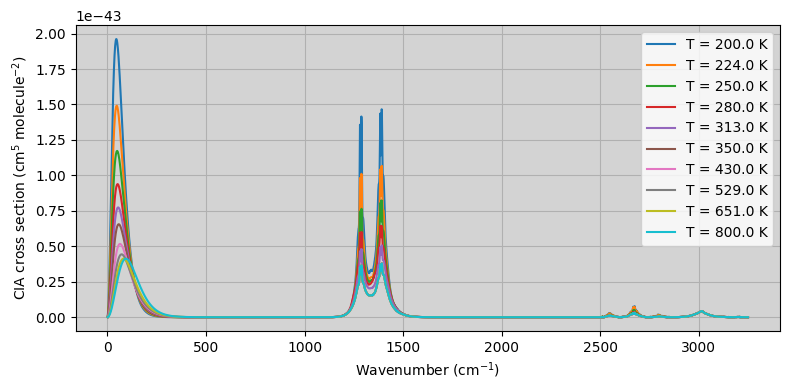

In [11]:
#Plotting all the cases
fig,ax1 = plt.subplots(1,1,figsize=(8,4))

for i in range(ntempg):
    
    ax1.plot(waveg,ktot[:,i],label='T = '+str(temp_grid[i])+' K')
    
ax1.legend()
ax1.set_facecolor('lightgray')
ax1.grid()
ax1.set_xlabel('Wavenumber (cm$^{-1}$)')
ax1.set_ylabel('CIA cross section (cm$^{5}$ molecule$^{-2}$)')
plt.tight_layout()

## 3. Writing the CIA table into HDF5 file with NemesisPy format

Finally, we want to write this table in a format compatible with NemesisPy. In particular, the latest version of NemesisPy can read CIA look-up tables written in an HDF5 format. These tables can be easily written or read using the built-in functions within the CIA class.

In [12]:
#Inlcuding all the values in the CIA class
CIA = CIA_0(NPAIR=1,IPAIRG1=[2],IPAIRG2=[2],INORMALT=[2])

CIA.NT = ntempg
CIA.NWAVE = nwaveg

CIA.WAVEN = waveg
CIA.TEMP = temp_grid

k_cia = np.zeros((1,CIA.NT,CIA.NWAVE))
k_cia[0,:,:] = ktot.T

CIA.K_CIA = k_cia

CIA.assess()

filename = 'CO2-CO2_HITRAN'
CIA.write_ciatable_hdf5(filename)


## 4. Reading the CIA table from the HDF5 file

Once we have created our CIA table, it can be easily read using the built-in functions in NemesisPy. In particular, the CIA table will fill all the information of the CIA class.

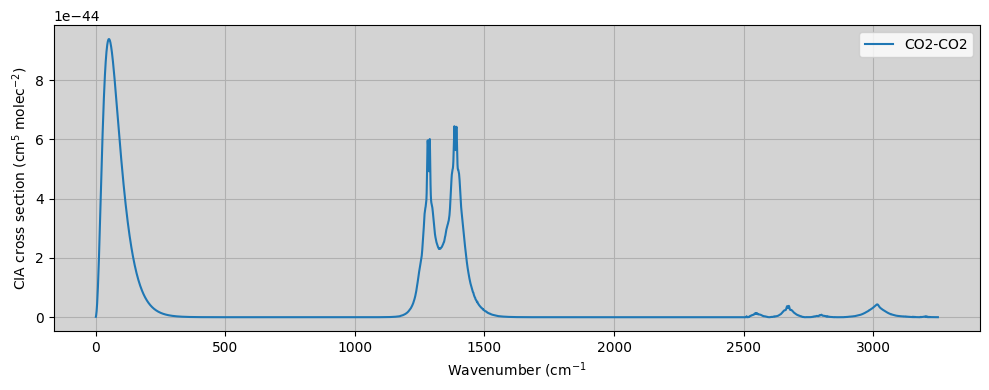

In [13]:
#Reading the CIA table
CIA = CIA_0()
CIA.read_ciatable_hdf5(filename)

#Making plot
CIA.plot_cia()